# A FOSS (Free and Open-source) Solution To Working With Data and Creating Data Visualizations
## **This Presentation Can Be Found Here:**
## [https://rayvoelker.github.io/misc/2020-neiug](https://rayvoelker.github.io/misc/2020-neiug)

<table>
        <tr>
            <td style='vertical-align: top; padding-top: 0px;'><img src='CHPL_Brandmark_full color.png' width='500px'></td>
            <td align='left'>
<pre style='font-size: 1.5em; text-align:left; '>
Ray Voelker
ILS Developer 
/ System Administrator

ray.voelker@cincinnatilibrary.org

Cincinnati &amp; Hamilton County 
Public Library

https://cincinnatilibrary.org
</pre>
            </td>
        </tr>
</table>

## Technology / Software Used Here

<table>
        <td>
            <img src='python.png' width='200px'>
        </td>
        <td>
            <a href='https://www.python.org/'>python.org</a>
        </td>
        <td>
            Python is a programming language that lets you work more quickly and integrate your systems more effectively.
        </td>
    </tr>
    <tr>
        <td>
            <img src='pandas.png' width='200px'>
        </td>
        <td>
            <a href="https://pandas.pydata.org/">pandas.pydata.org</a>
        </td>
        <td>
            Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
            built on top of the Python programming language.
        </td>
    </tr>
    <tr>
        <td>
            <img src='sqla_logo.png' width='200px'>
        </td>
        <td>
            <a href='https://www.sqlalchemy.org/'>sqlalchemy.org</a>
        </td>
        <td>
            SQLAlchemy is the Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.
        </td>
    </tr>
    <tr>
        <td>
            <img src='altair-logo-light.png' width='150px'>
        </td>
        <td>
            <a href='https://altair-viz.github.io/'>altair-viz.github.io</a>
        </td>
        <td>
            Altair is a declarative statistical visualization library for Python, based on Vega and Vega-Lite, and the source is available on GitHub
        </td>
    </tr>
    <tr>
        <td>
            <img src='jupyter_logo.png' width='100px'>
        </td>
        <td>
            <a href='https://jupyter.org/'>jupyter.org</a>
        </td>
        <td>
            The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning, and much more.
        </td>
    </tr>
</table>

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import altair as alt

# vars is a python file that sets pg_username and pg_password
import vars

### Connect to Database (**SQLAlchemy**)

Below is an example of how to connect to the **Sierra PostgreSQL database** using **SQLAlchemy**

In [2]:
# create our connection string for connecting to our Sierra database
connection_uri = 'postgres://{}:{}@sierra-db.plch.net:1032/iii'.format(vars.pg_username, vars.pg_password)

# use sqlalchemy to create our database connection
'''
The Engine is not synonymous to the DBAPI connect function, which represents 
just one connection resource - the Engine is most efficient when created just 
once at the module level of an application, not per-object or per-function call.

https://docs.sqlalchemy.org/en/13/core/connections.html
'''
con = create_engine(connection_uri)

### Query the Sierra Database and Store Results in Pandas DataFrame

In [3]:
# * simple example query to return 10 bib record numbers
# * use the read_sql() feature of pandas to read SQL query into a DataFrame
# * print the dataframe

sql = """
    SELECT
    r.id, r.record_type_code, r.record_num
    FROM
    sierra_view.record_metadata as r
    WHERE
    r.record_type_code = %s
    AND r.campus_code = ''
    LIMIT %s
"""

# read SQL query into a DataFrame.
df = pd.read_sql(sql=sql, con=con, params=['b', 10])

# print the dataframe
print(df)

             id record_type_code  record_num
0  420908795854                b     2000846
1  420909794181                b     2999173
2  420909440444                b     2645436
3  420908173485                b     1378477
4  420908173741                b     1378733
5  420908173430                b     1378422
6  420908479546                b     1684538
7  420909332877                b     2537869
8  420908173717                b     1378709
9  420908795881                b     2000873


### Query Database (Aggregate)

Suppose now that we wanted to visualize how many bib records are created in our system **per month**...

In [4]:
# * query to return aggregated counts of number of records created per month (month_created)
# * use the read_sql() feature of pandas to read SQL query into a DataFrame
# * print the dataframe

sql = """
SELECT
substring(date(r.creation_date_gmt)::TEXT from 1 for 7) as month_created,
count(*) as count

FROM
sierra_view.record_metadata as r

WHERE
r.record_type_code = 'b'

GROUP BY
month_created

ORDER BY
month_created
"""

df = pd.read_sql(sql=sql, con=con)
print(df)

    month_created    count
0         2012-06  1789664
1         2012-07     3546
2         2012-08     5699
3         2012-09    11146
4         2012-10     3895
..            ...      ...
97        2020-07     6231
98        2020-08     8134
99        2020-09     8844
100       2020-10      711
101          None        2

[102 rows x 2 columns]


In [5]:
# Here are some basic things you can do with a pandas DataFrame...

# df.info()                               # Print a concise summary of a DataFrame.
# df.shape                                # Return a tuple representing the dimensionality of the DataFrame.
# df.head()                               # Returns the first `n` rows for the object
# df.tail()                               # Return the last `n` rows
# df.columns                              # The column labels of the DataFrame.
# df.keys()                               # This is index for Series, columns for DataFrame.
# df.describe()                           # Generate descriptive statistics.
# df['count'].describe()                  # Generate descriptive statistics (on a single column).
# df[df['month_created'] == '2020-09']    # Filter


# Filter the DataFrame (send results to another new DataFrame)
source = df[df['month_created'] >= '2019']

# print the head (first 5 rows)
print( source.head() )

   month_created  count
79       2019-01  14163
80       2019-02  10956
81       2019-03  26770
82       2019-04  11488
83       2019-05  13009


### Plot Data (**Altair**)

Next, we create a simple plot of our data

In [6]:
# Generate the Altair chart from our filtered data:
alt.Chart(source).mark_bar().encode(
    x='month_created:O',
    y='count'
).properties(
    title='Bib Records Created Per Month (Year >= 2019)',
    width=800
)

alt.Chart(...)

In [7]:
# change it to a line chart!

alt.Chart(source).mark_line().encode(
    x='month_created:T',
    y='count',
    tooltip=['month_created:T', 'count']
).properties(
    title='Bib Records Created Per Month (Year >= 2019)',
    width=800
)

alt.Chart(...)

In [8]:
# Same query as before, but not bring in PATRON and ITEM records to aggregate on
sql = """
SELECT
substring(date(r.creation_date_gmt)::TEXT from 1 for 7) as month_created,
CASE r.record_type_code
    WHEN 'b' THEN 'bib record'
    WHEN 'p' THEN 'patron record'
    -- lets bring this in too, but remember to filter it out in the next plot!
    WHEN 'i' THEN 'item record'
END AS record_type,
count(*) as count

FROM
sierra_view.record_metadata as r

WHERE
r.record_type_code IN ('b', 'p', 'i')

GROUP BY
month_created,
r.record_type_code

ORDER BY
month_created
"""

df = pd.read_sql(sql=sql, con=con)

print(df)

    month_created    record_type    count
0         2012-06     bib record  1789664
1         2012-06    item record  3708303
2         2012-06  patron record        5
3         2012-07     bib record     3546
4         2012-07    item record  2037229
..            ...            ...      ...
301       2020-10    item record     2524
302       2020-10  patron record      375
303          None     bib record        2
304          None    item record       60
305          None  patron record        6

[306 rows x 3 columns]


In [9]:
'''
Plot bib and patron record ... rembering to filter out the item records!
'''

# Create an new DataFrame ('source') that is returned from filtering our original DataFrame:
source = df[(df['month_created'] >= '2019') 
            & (df['record_type'].isin(['bib record', 'patron record'])) ]

# Generate the Altair chart from our filtered data:
bib_v_patron = alt.Chart(source).mark_line().encode(
    x='month_created:T',
    y='count',
    color='record_type',
    tooltip=['month_created:T', 'count', 'record_type']
).properties(
    title='Bib Records and Patron Records Created Per Month (Year >= 2019)',
    width=800
)

# display the chart
bib_v_patron

alt.Chart(...)

In [10]:
# compare bib and item created per month
source = df[
    (df['month_created'] >= '2019') 
            & (df['record_type'].isin(['bib record', 'item record'])) ]

bib_v_item = alt.Chart(source).mark_line().encode(
    x='month_created:T',
    y='count',
    color='record_type',
    tooltip=['month_created:T', 'count', 'record_type']
).properties(
    title='Bib Records and Item Records Created Per Month (Year >= 2019)',
    width=800
)

# display the chart
bib_v_item

alt.Chart(...)

In [11]:
'''
concatinate the two charts together!

NOTE: The scales don't match ... we'd need to get a little fancier to make sure the scales match
'''

alt.vconcat(bib_v_patron, bib_v_item)

alt.VConcatChart(...)

In [12]:
# get "fancy" and set the scale on the first one to match the second

# use the max() method on the 'count' column to get a max value for that column of the DataFrame
max_scale = df[(df['month_created'] >= '2019') 
   & (df['record_type'].isin(['bib record', 'item record']))
  ]['count'].max()

print('max_scale: {}'.format(max_scale))

max_scale: 61847


In [13]:
'''
Plot bib and patron record ... AGAIN! (with the scale to match bib and items)
'''

source = df[(df['month_created'] >= '2019') 
            & (df['record_type'].isin(['bib record', 'patron record'])) ]

bib_v_patron = alt.Chart(source).mark_line().encode(
    x='month_created:T',
    y=alt.Y('count',
            scale=alt.Scale(domain=(0, max_scale)),
           ),
    color='record_type',
    tooltip=['month_created:T', 'count', 'record_type']
).properties(
    title='Bib Records and Patron Records Created Per Month (Year >= 2019)',
    width=800
)

# display the charts ... but now with the same SCALE!!
alt.vconcat(bib_v_patron, bib_v_item)

alt.VConcatChart(...)

---
### TRANSACTION DATA!!!

In [14]:

# For a specific date, examine the relationship between transactions of types
# "checkout" and "filled hold" 

# NOTE: "filled hold" transactions are a portion of the "checkout"

# QUERY OVERVIEW:
# * SELECT the op_code ('checkout' or filled hold') and the location
# * COUNT aggregated op_code and location
# * GROUP BY op_code and the location
# * WHERE the transaction date is a specific date

search_date = '2020-09-21'

sql = """
SELECT
CASE c.op_code
    WHEN 'o' THEN 'checkouts total'
    WHEN 'f' THEN 'filled holds'
END as op_name,
(
    select
    m.location_code
    from
    sierra_view.statistic_group_myuser as m
    where
    m.code = c.stat_group_code_num
) as transaction_location_code,
date(c.transaction_gmt) as transaction_date,
count(*) as count

FROM
sierra_view.circ_trans as c

WHERE
-- transaction operations: 'checkout' and 'filled hold' 
c.op_code IN ('o', 'f')
AND date(c.transaction_gmt) = date(%s)
AND ptype_code != '196' -- exclude our admin card type

GROUP BY
op_name,
transaction_location_code,
transaction_date
"""

df = pd.read_sql(sql=sql, con=con, params=[search_date])
print(df)

            op_name transaction_location_code transaction_date  count
0   checkouts total                         1       2020-09-21    751
1   checkouts total                        an       2020-09-21    806
2   checkouts total                        av       2020-09-21     47
3   checkouts total                        ba       2020-09-21    764
4   checkouts total                        bh       2020-09-21     62
..              ...                       ...              ...    ...
79     filled holds                        sm       2020-09-21    359
80     filled holds                        wh       2020-09-21     65
81     filled holds                        wt       2020-09-21     32
82     filled holds                        ww       2020-09-21     67
83     filled holds                        wy       2020-09-21    112

[84 rows x 4 columns]


In [15]:
# first set the transaction date to a datetime that pandas / altair can use in the chart display (hover-over)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# filter the dataframe
# source = df[df['op_name'] == 'checkouts total']
source = df

alt.Chart(source).mark_bar().encode(
    
    x=alt.X('transaction_location_code'),
    y=alt.Y('count', ),
    color='op_name',
    tooltip=['transaction_date', 'transaction_location_code', 'op_name', 'count']
).properties(
    title='Total Checkouts Per Location - {}'.format(search_date),
    width=800,
).configure_title(
    # fontSize=20,
    anchor='start',
)

alt.Chart(...)

In [16]:
# sort on the count, or y axis
# source = df[df['op_name'] == 'checkouts total' ]
source = df

alt.Chart(source).mark_bar().encode(
    
    x=alt.X('transaction_location_code', sort='-y'),
    y=alt.Y('count', ),
    tooltip=['transaction_date', 'transaction_location_code', 'op_name', 'count'],
    color='op_name',
).properties(
    title='Total Checkouts Per Location - {}'.format(search_date)
).configure_title(
    # fontSize=20,
    anchor='start',
)

alt.Chart(...)

In [17]:
# or maybe you'd like to see it vertically?
# sort on the count, or y axis
# flip the axis ...

# source = df[df['op_name'] == 'checkouts total' ]
source = df

# place the chart into a variable
chart = alt.Chart(source).mark_bar().encode(
    
    x=alt.X('count', ),
    y=alt.Y('transaction_location_code', sort='-x'),
    tooltip=['transaction_date', 'transaction_location_code', 'op_name', 'count'],
    color='op_name'
).properties(
    title='Total Checkouts Per Location - {}'.format(search_date)
).configure_title(
    # fontSize=20,
    anchor='start',
)

# display the chart
chart

alt.Chart(...)

### Saving and Sharing Altair Charts

* One way is to use the .save() method and export directly to a PNG, or other file type...

In [18]:
# save the visulization in a png in the local directory...
chart.save('my_awesome_chart.png')


!file my_awesome_chart.*

my_awesome_chart.png: PNG image data, 563 x 899, 8-bit/color RGBA, non-interlaced


* Another way is to click on the "three dots" menu and either save it or share it ...

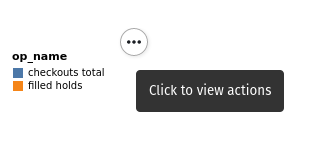

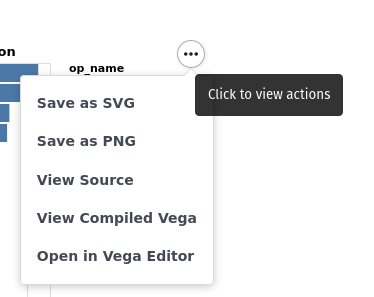


* Opening in the Vega Editor, and then clicking "Share" is a nice way to share interactive versions of the chart 

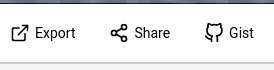

WARNING: the urls can get HUGE! (since sharing the chart encodes all the data into the URL query itself):

[click to view my visualization!](https://vega.github.io/editor/#/url/vega-lite/N4Igxg9gdgZglgcxALlANzgUwO4tJKAFzigFcJSBnAdTgBNCALFAFgAY2AacaYsiygAlMiRoRQBmDgF9uxQgBtMeEAEMoYRhABOKEJUKrt46bJB1VhlVFUBbZcnOXVAWgAcdGG0ye3MAIx0AGwATG4ARgCc-iFsLP7esRIwqhIhIf4gZrZGANZ64UYg3JgaEHQkSKg8CjoqhACeAA4OIFAQtiSqCsUg8JgKdHoQTQD6NvZZchAQCsRNKADaoI0teoSYtk063b39g+va6pSqYMTQoxYbUyvNre2dNj3c+0OOhEdQJ2dwF7Vgll+UFGkDoylktzWjgeXWefSwB0cI3GdnBnEhrQAjqR1PJAWhlC8EW8eKQiFkALrcAAe9TuemxuLghmIBL2xL0kDJJm4DTpULaHVh7IGJI+x1O52B-0BF1BhP0OnEjhctNMcmZSj0ABUIIYFAACADCjEwYFyFEIlANAAVMNoDQAZCAAqUGlwG2KxFxsSIuDK9AAklE0m1UejEhCalGQAHpYwSEKoAHQIZmMUjhZO-WMh005BOYJMuBTMzAJljJtzJ-zJgBWlGgvSuqkomCtKhb7k83l8AWCYSiMTiCUwSRSaQDyGWIGRE1aofNluthD1uzkn2+UtGMu38r0mQ3Ep+FyurS9bB9foy2o4yDvHF6XPJyAA7ABWfwQ2djeec01LqQVoGqu+q9OKXySkCO4urKwL7o46jgZuUGnpY55sN6vr+v4t5sPe+GPtwz7Km4bBBN+c6ov+ZoWkBK5rnCEFbtBu7QQhahoMhx7bmeegXleOF4QRBFPhQL4sK+lG-tRjiLnRwGgeuIDMah0qwXu5StIU3GQSewJ8Y4AnYTeD6EWwYncigr5BCw0kopMckAQpDFgUeenbmxcpaQUzDuSxaHXEZmGXiZuFmaJxHicqoT2X+Tm0cuIGMbpAXqa67E+U5qVqZc6H8SFgmmeZkWki+bhuHFsngM5SVKUxKH6TBGXeWCnINTx0GGSAxnXuFJVEWVyohJEbBVY5NWJfRyVuSpjWeRpmVtXJEA5U13W9UJEWDSRKCRHZ6I-g5C61dN9VrQtLXwVl4C6P5uUbYVYXCWZlkvv4X6HVRE3yXVKX3U1XnXct4BcQDvH5cFWF9S95lvcqEgSO+40nVNin-XNnV-ItrWtHQCzg11kM9U9MPbRZUVWcgIQsCEKM0YB6OzapgM48DePiITgUYdDW0DRTQ0oO+NP0wljOucpLOXXBII3ZgBOYx5RNBSTvPFSJO3RdZdNfTJP2nUzkvzaxbOyyDMCrVzBnE5t6uvZT737aLk3izNRtY+lMscQgCpS8rPOhWT-Pw9ZQRjbrx0My5bsdUr2NXWbrQIH5itpXlKu2-1GsC7tb6faA32o6751W81Xs3Qgd2pw9Nuk3z2ch8gQRBJEzu-WdGN+-H5cg4w4al49atZ-bgvICwQTIxH8Uu9HJfV6zCccYwCtd9bGd13bcMO8q7AUVP1Xt4bsdp0Did6AoYPzxD69D7DpW57T4cF3rRez53xvd5pIM5Bd-sFbf5NG4sEiBINuBsJbH1yqfDitghgD1rgA4O28UDpDAWjCBv9P5LVaLYWwmC14ByKsPLeo8Qivh1s-SOYs37Mw-p7L+OCoD4PToQ56gDkHIA+hQo609D4YNLtAm6thLZXz-lDQO9cR4PxFvvfW6CY7MMEd-Tmojub-wkZve+WtqZSVka-P6tCPZlwYXoWwuB4E3w0cQrRVN-CRFbnoqOBj3Zx3odgvQUAq6rxYeoohd9NZUzSHvShvDwEKIEabDiXxmGDysf4nO2iYi6JCQfMJc9vFKPuOY1RBDfFsKQaQkIwSeGpPkekuhxj3FIn7jknx4i-HsNIa+ZJJS5HF3fkYzJwwXFp1iQ0gpudimFycR3QxrjKm42GJQGJCC4mNNzu+RZaD2ljJPpEm6TRIHrVmf0huHCQjviGS-EZR9FHrJBtoX2FS+n5L2aQz8yyaE9Kgec1olBwgzMsbsqR2jIgtOGdQ5xWzpYmMcJQFO3iblBzuQ-WyjygVnMXjdSgeCLGsOhT8qmbhRrwtGc8hePdWjYAhdcnZtzMXvSRri05ESkUg2wCoyFZKMUkNzjESeKS2lPOBSbOlRLslMq+eS1liS3CgMcYCvFPKsGTMcNgPkaK8kspsS+Gm-zjmOHgAoJQdADRaEGNM2lhKDyfPRZIkVgSgjis5a0LVOq9WzDoIa2pXTEJMMVfU4VKqd7+AOjavQdqfAOoNYi41iFL6CrNZogJL4jlUPhNqoN+qnWhtBSAHSHrVZzIGdoiQYdnaBt1cm51GTXm+VNUq813qUD+HVfGwtwaU1GrTZoCtnrlUxoRta1ptq4CJqLY6ktFTXXgGlbk9tVbO01pAQWvt9ri2pqqTwNtWbvkWpfIjWd-bG1Ds6WWuSXjSVCo7QkrFW752DsXbK0GK7M7xMbv4d8lUJUJovSG5tS78a3o3tYqdnDMLnqTZej916GDfsQTC0Vdbp4NoXSB9meh5bgezZB2xfqe0BrnUB99Lr919BEZGyt0bT2xuff6zVWGB04dLXyvQPtkNrurdTK1gGqNNtw7RxwycGNer-e+btALX3YfYzRsNIBK48ZPY3CQ49WM7qvQhxwfdJOTpI8qfwFU5NwY42J5eKniON1iByjDFHt3adE2mi++nf1qckHELTwGdNpp-pmu98zEnkIc9R4deHYHWfvRw2tXmRM+c4yAXB-n3NU2iMF3d4yR22HdbUqFqmgECY1UJtjcW1lheEZFnNtjYovtg45izS7bCMqPVGmzhn0v1so-J+DZ9HBmPy6h96bBjOCZK95vdYXPFtYpeptg0Hqo9ZC31sT0TXM-oC6PV8T8TOZca05pdUABVVaIzVwLvpYsKea7OGphGJ0GcC3mvbTWOIQHxdfarc3BkXdW9eiA2Wa7HtSxwyIXWMvjdewStNmzBvrvU4+x7ZXr2XKB0x316HusNfM6FsT7yod-vzcV+HpXEdpvBSj2z1MWDffq2ZzHk3seouS8yj7o8kYOPI8thHpOl3Etx43CeYOsdM8q0YlLp3qfcLh8T3r8W8PYA29zynvPBmjYmr9-bHF5Us8CzEaQFJTBAA/view)


# THANK YOU!

## **This Presentation Can Be Found Here:**
## [https://rayvoelker.github.io/misc/2020-neiug](https://rayvoelker.github.io/misc/2020-neiug)

<table>
        <tr>
            <td style='vertical-align: top; padding-top: 0px;'><img src='CHPL_Brandmark_full color.png' width='500px'></td>
            <td align='left'>
<pre style='font-size: 1.5em; text-align:left; '>
Ray Voelker
ILS Developer 
/ System Administrator

ray.voelker@cincinnatilibrary.org

Cincinnati &amp; Hamilton County 
Public Library

https://cincinnatilibrary.org
</pre>
            </td>
        </tr>
</table>